In [1]:
# Install library yang diperlukan
%pip install split-folders

In [2]:
# Import Library
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import splitfolders
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image # Import Image from PIL

In [3]:
from google.colab import drive  # Mengimpor modul drive dari google.colab untuk mengakses Google Drive
# Me-mount Google Drive ke direktori /content/drive agar file di Google Drive dapat diakses
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 1. Pembersihan Data dan Konversi ke RGB
def clean_dataset(dataset_path):
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    # Coba buka gambar
                    img = Image.open(img_path)
                    img = img.convert('RGB')  # Mengonversi gambar ke RGB
                    img.verify()  # Verifikasi gambar
                except (IOError, SyntaxError) as e:
                    print(f"Removing invalid image: {img_path}")
                    os.remove(img_path)  # Hapus gambar yang tidak valid

# Panggil fungsi pembersihan untuk dataset
clean_dataset("/content/drive/MyDrive/skripsi/apis/Dataset Tomat 1")

In [5]:
# Jalankan splitfolders dengan rasio 70-15-15
splitfolders.ratio(
    "/content/drive/MyDrive/skripsi/apis/Dataset Tomat 1",
    output="/content/drive/MyDrive/skripsi/apis/output_dataset22",
    seed=42,
    ratio=(0.7, 0.15, 0.15),
    group_prefix=None
)

Copying files: 1000 files [00:15, 64.44 files/s]


In [6]:
# 3. Parameter
image_size = (224, 224)  # Mengubah ukuran input menjadi 224x224
batch_size = 32  # Mengurangi batch size untuk memori yang lebih baik

In [7]:
# 4. Data Augmentation dan Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data training, validation, dan test
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/skripsi/apis/output_dataset22/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_data = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/skripsi/apis/output_dataset22/val',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_data = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/skripsi/apis/output_dataset22/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 700 images belonging to 4 classes.
Found 148 images belonging to 4 classes.
Found 152 images belonging to 4 classes.


In [8]:
# 5. Membangun Model
# Menggunakan ResNet50 sebagai base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))  # Mengubah ukuran input menjadi 224x224
)

# Freeze layer pretrained (hanya membekukan layer awal)
for layer in base_model.layers[:-20]:  # Membiarkan 20 layer terakhir bisa di-train
    layer.trainable = False
# Tambahkan custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Menambah neuron
x = tf.keras.layers.Dropout(0.5)(x)    # Menambah dropout untuk mengurangi overfitting
output = Dense(len(train_data.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
# 6. Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Learning rate lebih kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# 7. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [11]:
# 8. Training Model
history = model.fit(
    train_data,
    steps_per_epoch=len(train_data),
    validation_data=val_data,
    validation_steps=len(val_data),
    epochs=50,  # Meningkatkan jumlah epoch
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


22/22 ━━━━━━━━━━━━━━━━━━━━ 223s 9s/step - accuracy: 0.3826 - loss: 1.3557 - val_accuracy: 0.2500 - val_loss: 1.6240 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 236s 8s/step - accuracy: 0.4945 - loss: 1.0948 - val_accuracy: 0.3581 - val_loss: 1.5344 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.6004 - loss: 0.9001 - val_accuracy: 0.3311 - val_loss: 1.5048 - learning_rate: 1.0000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.6663 - loss: 0.8153 - val_accuracy: 0.2973 - val_loss: 1.4291 - learning_rate: 1.0000e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.6613 - loss: 0.7743 - val_accuracy: 0.2635 - val_loss: 1.4340 - learning_rate: 1.0000e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 186s 8s/step - accuracy: 0.6570 - loss: 0.7825 - val_accuracy: 0.2500 - val_loss: 1.4443 - learning_rate: 1.0000e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.6453 - loss: 0.7

5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.7977 - loss: 0.5714

Akurasi Test: 84.87%


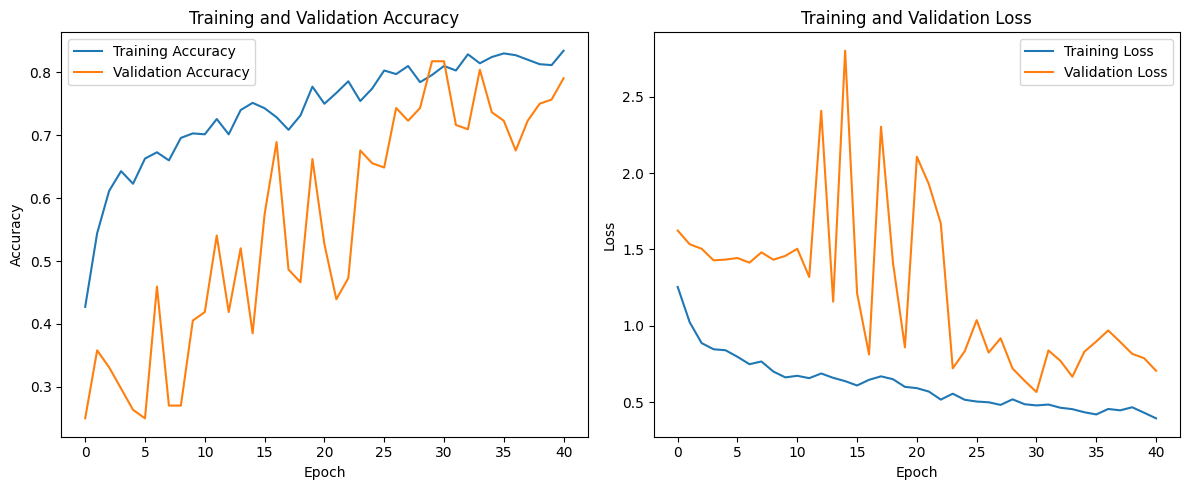

In [12]:
# 9. Evaluasi Model
# Evaluasi pada test set
test_loss, test_acc = model.evaluate(test_data)
print(f"\nAkurasi Test: {test_acc * 100:.2f}%")

# Plot akurasi dan loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step


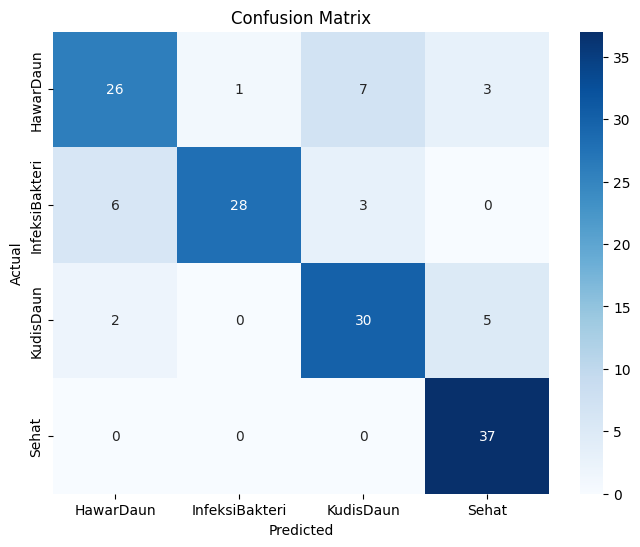

In [13]:
# 10. Confusion Matrix dan Classification Report
val_data.reset()
y_true = val_data.classes
y_pred = model.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(val_data.class_indices.keys()),
            yticklabels=list(val_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_data.class_indices.keys())))


Classification Report:
                precision    recall  f1-score   support

     HawarDaun       0.76      0.70      0.73        37
InfeksiBakteri       0.97      0.76      0.85        37
     KudisDaun       0.75      0.81      0.78        37
         Sehat       0.82      1.00      0.90        37

      accuracy                           0.82       148
     macro avg       0.83      0.82      0.82       148
  weighted avg       0.83      0.82      0.82       148



In [15]:
# 11. Simpan Model
model.save('/content/drive/MyDrive/skripsi/apis/model_resnet50_tomat22.h5')  # Simpan model dalam format HDF5

# Jika ingin menyimpan dalam format SavedModel (direktori)
# model.save('/content/drive/MyDrive/skripsi/apis/saved_model_resnet50_tomat')